In [1]:
import importlib

import settings
import VPINN_tri_final
import mesh_lib

import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
from GaussJacobiQuadRule_V3 import Jacobi, DJacobi, GaussLobattoJacobiWeights
import os 

importlib.reload(settings)
importlib.reload(mesh_lib)
importlib.reload(VPINN_tri_final)

from settings import *
from mesh_lib import *
from VPINN_tri_final import *
#tf.config.run_functions_eagerly(True)


os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

2023-11-23 12:46:02.663241: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-23 12:46:03.372739: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


settings_lib imported 
interpolator_lib imported
mesh_lib imported
settings_lib imported 
mesh_lib imported


In [2]:
#to do
#error 
#seed 
#writing stuff to a csv file 



degree =  2  , local dof =  6  internal dof =  0  points inside each edge =  1
[[0 0]
 [1 0]
 [0 1]
 [1/2 0]
 [1/2 1/2]
 [0 1/2]]


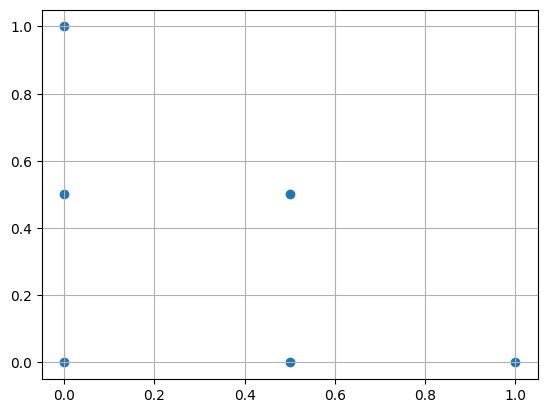

In [3]:
basis=interpolator(2,False,False,points=None)

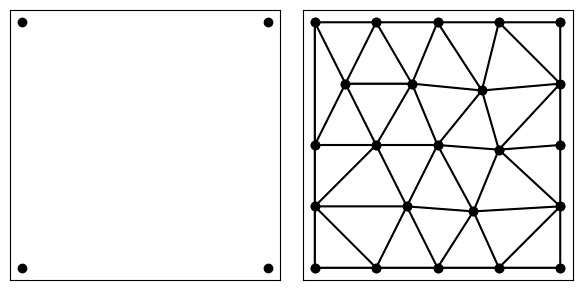

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import triangle as tr

# Step 1: Generate a fine mesh
A = dict(vertices=np.array(((0, 0), (1, 0), (1, 1), (0, 1))))
B = tr.triangulate(A, 'qnea0.05')
tr.compare(plt,A,B)

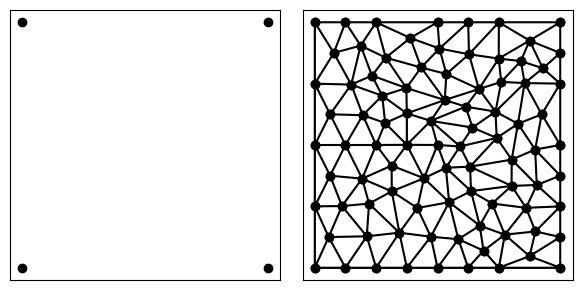

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import triangle as tr



# Step 1: Generate a fine mesh
A = dict(vertices=np.array(((0, 0), (1, 0), (1, 1), (0, 1))))
B = tr.triangulate(A,'qnea0.01')

tr.compare(plt, A, B)

[[75 76]
 [74 76]
 [74 75]
 [12 26]
 [12 14]
 [14 26]
 [ 7 15]
 [ 9 15]
 [ 7  9]
 [ 7 20]
 [15 20]
 [23 46]
 [24 46]
 [23 24]
 [ 5  9]
 [ 5 35]
 [ 9 35]
 [14 15]
 [10 14]
 [10 15]
 [ 5 10]
 [10 12]
 [ 5 12]
 [21 24]
 [ 7 21]
 [ 7 24]
 [37 43]
 [42 43]
 [37 42]
 [ 8 40]
 [ 0  8]
 [ 0 40]
 [16 19]
 [17 19]
 [16 17]
 [15 22]
 [14 22]
 [21 46]
 [14 27]
 [22 27]
 [23 36]
 [36 38]
 [23 38]
 [13 16]
 [16 33]
 [13 33]
 [ 9 10]
 [33 56]
 [13 56]
 [17 20]
 [20 21]
 [17 21]
 [28 29]
 [18 29]
 [18 28]
 [ 3 12]
 [ 3 26]
 [13 19]
 [13 25]
 [19 25]
 [17 22]
 [19 22]
 [17 30]
 [16 30]
 [32 56]
 [ 6 56]
 [ 6 32]
 [33 58]
 [16 58]
 [13 32]
 [25 32]
 [ 9 36]
 [ 7 36]
 [ 4 21]
 [ 4 30]
 [21 30]
 [20 22]
 [24 36]
 [38 41]
 [38 43]
 [41 43]
 [35 36]
 [23 47]
 [23 41]
 [41 47]
 [27 29]
 [14 29]
 [25 27]
 [19 27]
 [ 3 28]
 [26 28]
 [25 29]
 [26 29]
 [18 25]
 [ 4 73]
 [30 73]
 [84 87]
 [65 84]
 [65 87]
 [54 56]
 [ 6 54]
 [ 6 18]
 [18 32]
 [16 66]
 [58 66]
 [34 70]
 [34 59]
 [59 70]
 [56 60]
 [54 60]
 [ 5  8]
 

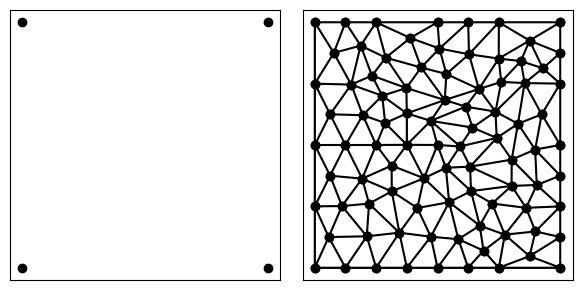

In [6]:

#edges flipping 

for i in range(len(B['edges'])):
    ii=B['edges'][i][0]
    jj=B['edges'][i][1]

    if ii>jj:
            B['edges'][i][0],B['edges'][i][1]=B['edges'][i][1],B['edges'][i][0]

tr.compare(plt, A, B)

print(B['edges'])

In [7]:

#util functions

def get_triangle_edges(triangle_vertices,edges):
    triangle_edges = []
 

    keep=np.zeros((3,),dtype=np.int64)

    for i in range(3):
        ii=triangle_vertices[i].copy()
        jj=triangle_vertices[(i + 1) % 3].copy()
        

        if(ii>jj):
            edge=np.array([jj,ii])
        else:
            edge=np.array([ii,jj])

        index= np.where(np.all(edges == edge, axis=1))[0][0]
        
        triangle_edges.append(index)

        if ii>jj:
            keep[i]=1

    triangle_edges=np.array(triangle_edges)
        
    return keep,triangle_edges

In [8]:
#flipping part + edges
l=[]
temp=[]
for triangle in B['triangles']:
    keep,t=get_triangle_edges(triangle,B['edges'])
    l.append(keep)
    temp.append(t)



keep=np.asarray(l)
edges_index_inside_triangle=np.asarray(temp)

In [9]:
B['keep']=keep
B['edges_index_inside_triangle']=edges_index_inside_triangle

In [10]:
B.keys()

dict_keys(['vertices', 'vertex_markers', 'triangles', 'neighbors', 'edges', 'edge_markers', 'keep', 'edges_index_inside_triangle'])

In [11]:
print(B['edges_index_inside_triangle'][0][0])

0


In [12]:
#exp
n_vertices=len(B['vertices'])
n_traingles=len(B['triangles'])
n_edges=len(B['edges'])

n_inside_edge=basis.n_inside_edge
n_inside=basis.n_inside

vertices_contribution=np.zeros((n_vertices,1))
edges_contribution=np.zeros((n_edges,n_inside_edge))
inside_contribution=np.zeros((n_traingles,n_inside))




for index,triangle in enumerate(B['triangles']):


    if (B['vertex_markers'][triangle[0]]==0):
            vertices_contribution[triangle[0]]=1
    else:
          vertices_contribution[triangle[0]]=2

    if (B['vertex_markers'][triangle[1]]==0):
            vertices_contribution[triangle[1]]=1
    else:
          vertices_contribution[triangle[1]]=2    

    if (B['vertex_markers'][triangle[2]]==0):
            vertices_contribution[triangle[2]]=1
    else:
          vertices_contribution[triangle[2]]=2
    

    if(B['edge_markers'][B['edges_index_inside_triangle'][index][0]]==0):
           
           edges_contribution[B['edges_index_inside_triangle'][index][0]]+=3

    if(B['edge_markers'][B['edges_index_inside_triangle'][index][1]]==0):
           edges_contribution[B['edges_index_inside_triangle'][index][1]]+=3

    if(B['edge_markers'][B['edges_index_inside_triangle'][index][2]]==0):
           edges_contribution[B['edges_index_inside_triangle'][index][2]]+=3      



print(B['edges'])
print(edges_contribution)


    
                                   

[[75 76]
 [74 76]
 [74 75]
 [12 26]
 [12 14]
 [14 26]
 [ 7 15]
 [ 9 15]
 [ 7  9]
 [ 7 20]
 [15 20]
 [23 46]
 [24 46]
 [23 24]
 [ 5  9]
 [ 5 35]
 [ 9 35]
 [14 15]
 [10 14]
 [10 15]
 [ 5 10]
 [10 12]
 [ 5 12]
 [21 24]
 [ 7 21]
 [ 7 24]
 [37 43]
 [42 43]
 [37 42]
 [ 8 40]
 [ 0  8]
 [ 0 40]
 [16 19]
 [17 19]
 [16 17]
 [15 22]
 [14 22]
 [21 46]
 [14 27]
 [22 27]
 [23 36]
 [36 38]
 [23 38]
 [13 16]
 [16 33]
 [13 33]
 [ 9 10]
 [33 56]
 [13 56]
 [17 20]
 [20 21]
 [17 21]
 [28 29]
 [18 29]
 [18 28]
 [ 3 12]
 [ 3 26]
 [13 19]
 [13 25]
 [19 25]
 [17 22]
 [19 22]
 [17 30]
 [16 30]
 [32 56]
 [ 6 56]
 [ 6 32]
 [33 58]
 [16 58]
 [13 32]
 [25 32]
 [ 9 36]
 [ 7 36]
 [ 4 21]
 [ 4 30]
 [21 30]
 [20 22]
 [24 36]
 [38 41]
 [38 43]
 [41 43]
 [35 36]
 [23 47]
 [23 41]
 [41 47]
 [27 29]
 [14 29]
 [25 27]
 [19 27]
 [ 3 28]
 [26 28]
 [25 29]
 [26 29]
 [18 25]
 [ 4 73]
 [30 73]
 [84 87]
 [65 84]
 [65 87]
 [54 56]
 [ 6 54]
 [ 6 18]
 [18 32]
 [16 66]
 [58 66]
 [34 70]
 [34 59]
 [59 70]
 [56 60]
 [54 60]
 [ 5  8]
 

In [13]:
def find_h(mesh):
    h=-1
    for edges in mesh['edges']:
        vertices=mesh['vertices'][edges]
        h=max(h,np.sqrt((vertices[0,0]-vertices[1,0])**2 +(vertices[0,1]-vertices[1,1])**2))
        return h

In [14]:
find_h(B)

0.10857914134156313

In [15]:
tfk=tf.keras
tfkl=tf.keras.layers

In [16]:
model = tfk.models.Sequential()
model.add(tf.keras.Input(shape=(2,),dtype=tf.float64))
model.add(tfkl.Dense(10, activation='tanh',kernel_initializer="glorot_uniform",dtype=tf.float64,bias_initializer="glorot_uniform"))
model.add(tfkl.Dense(10, activation='tanh',kernel_initializer="glorot_uniform",dtype=tf.float64,bias_initializer="glorot_uniform"))
model.add(tfkl.Dense(10, activation='tanh',kernel_initializer="glorot_uniform",dtype=tf.float64,bias_initializer="glorot_uniform"))
model.add(tfkl.Dense(10, activation='tanh',kernel_initializer="glorot_uniform",dtype=tf.float64,bias_initializer="glorot_uniform"))
model.add(tf.keras.layers.Dense(1,activation='linear',kernel_initializer="glorot_uniform",dtype=tf.float64,use_bias=True))

2023-11-23 12:46:05.745919: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [17]:
print(model.summary())
print(model.input_shape)
print(model.output_shape)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                30        
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 10)                110       
                                                                 
 dense_3 (Dense)             (None, 10)                110       
                                                                 
 dense_4 (Dense)             (None, 1)                 11        
                                                                 
Total params: 371
Trainable params: 371
Non-trainable params: 0
_________________________________________________________________
None
(None, 2)
(None, 1)


In [18]:
print()

In [19]:
print(model.trainable_variables)

[<tf.Variable 'dense/kernel:0' shape=(2, 10) dtype=float64, numpy=
array([[-0.33350762, -0.6945878 , -0.25639855,  0.18112438, -0.5672207 ,
         0.25646681, -0.10824431,  0.1489837 , -0.22142392, -0.58727345],
       [-0.49347141,  0.47949807,  0.48161753,  0.40562649, -0.46879131,
         0.32269749,  0.59692539,  0.20569508, -0.01593494, -0.60568293]])>, <tf.Variable 'dense/bias:0' shape=(10,) dtype=float64, numpy=
array([ 0.30433406, -0.33859589, -0.16632985,  0.40648046, -0.15999787,
       -0.11418169, -0.20599933, -0.06535251, -0.16855286, -0.34560722])>, <tf.Variable 'dense_1/kernel:0' shape=(10, 10) dtype=float64, numpy=
array([[ 0.53913976, -0.24727816,  0.29800914,  0.42936972,  0.37033159,
         0.50832078, -0.1673869 ,  0.28285979, -0.44826464,  0.3287872 ],
       [-0.1051379 , -0.41467869,  0.10848924, -0.41827217, -0.41496486,
        -0.2969323 ,  0.44289732,  0.35740806,  0.07749211,  0.03742245],
       [ 0.36505507,  0.30501497,  0.25921368, -0.3975828 ,  0.4

In [20]:
from settings import *
N_tests = 2
N_elements = [5, 5]
params = {'scheme': 'VPINNs',
            'NN_struct': [2] + [5] * 3 + [1],
            'var_form': 1,
            'n_elements': tuple(N_elements),
            'n_test': [N_elements[0]*[N_tests], N_elements[1]*[N_tests]],
            'n_quad': 50,
            'n_bound': 80, # for every edge 
            'n_residual': 100,
            'domain': ((0.0, 1.0), (0.0, 1.0)),
            'Opt_Niter': 15000 + 1,
            'delta_test': 0.01,
            'N_test':N_tests}





277
degree =  2  , local dof =  6  internal dof =  0  points inside each edge =  1
[[0 0]
 [1 0]
 [0 1]
 [1/2 0]
 [1/2 1/2]
 [0 1/2]]


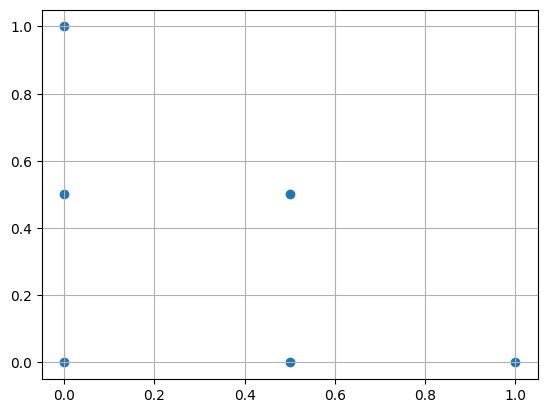

degree =  2  , local dof =  6  internal dof =  0  points inside each edge =  1
[[0 0]
 [1 0]
 [0 1]
 [1/2 0]
 [1/2 1/2]
 [0 1/2]]


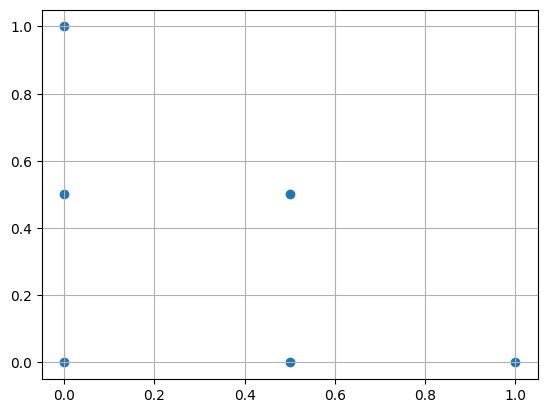

In [21]:
vp=VPINN(pb,params,B,model)

In [22]:
tf.reduce_mean(tf.square(model(vp.boundary_points) - vp.u_bound_exact))

<tf.Tensor: shape=(), dtype=float64, numpy=0.7815648037609751>

In [23]:
_,c,J,B_D,B_DD=vp.b.change_of_coordinates(vp.mesh['vertices'][vp.mesh['triangles'][0]])

t=np.array(vp.grad_test)[0]

print((B_D@t))
print()
xy_quad_element=(B_D@ vp.grad_test)


print(xy_quad_element)

[[-28.78846732 -19.40617289  -6.30883018   5.50341584 -17.51506705
  -10.76000209  -1.33017642   7.17440523  -2.8064279    0.52083628
    5.16557639   9.35457976   8.46697238   9.16700708  10.14423014
   11.02556916]
 [-11.76879784  -7.93329228  -2.57906564   2.24981023  -7.16020345
   -4.39871591  -0.54377947   2.9329149   -1.14727478   0.21291918
    2.11170062   3.82417573   3.4613196    3.74749555   4.14698679
    4.5072804 ]]

tf.Tensor(
[[[-28.78846732 -19.40617289  -6.30883018   5.50341584 -17.51506705
   -10.76000209  -1.33017642   7.17440523  -2.8064279    0.52083628
     5.16557639   9.35457976   8.46697238   9.16700708  10.14423014
    11.02556916]
  [-11.76879784  -7.93329228  -2.57906564   2.24981023  -7.16020345
    -4.39871591  -0.54377947   2.9329149   -1.14727478   0.21291918
     2.11170062   3.82417573   3.4613196    3.74749555   4.14698679
     4.5072804 ]]

 [[ -6.28616354   0.87477058  10.87117485  19.88674306  -6.28616354
     0.87477058  10.87117485  19.88674306

In [24]:
print(vp.xy_quad_total)

tf.Tensor(
[[[0.68122384 0.17525175]
  [0.70290904 0.1658122 ]
  [0.73318079 0.15263492]
  ...
  [0.73428996 0.22184877]
  [0.75125061 0.184902  ]
  [0.7665471  0.15158041]]

 [[0.0777708  0.85942287]
  [0.05964657 0.83392222]
  [0.0343458  0.79832425]
  ...
  [0.10378483 0.75364757]
  [0.05976157 0.75210035]
  [0.02005782 0.75070494]]

 [[0.23871165 0.50694183]
  [0.22867071 0.5336542 ]
  [0.21465393 0.57094371]
  ...
  [0.15082862 0.5336542 ]
  [0.16983075 0.57094371]
  [0.18696841 0.60457441]]

 ...

 [[0.88370781 0.05808841]
  [0.91080933 0.07368194]
  [0.94864207 0.09544994]
  ...
  [0.92574152 0.13641984]
  [0.95724035 0.13157579]
  [0.98564854 0.12720704]]

 [[0.6618921  0.18574455]
  [0.65596528 0.21519924]
  [0.64769166 0.25631692]
  ...
  [0.57831754 0.27469098]
  [0.6029804  0.29057357]
  [0.62522336 0.30489777]]

 [[0.78714397 0.32748629]
  [0.75202761 0.32390853]
  [0.70300644 0.3189141 ]
  ...
  [0.70264852 0.27908907]
  [0.67457289 0.29310608]
  [0.649252   0.30574776]]]

In [25]:
n_triangles=vp.n_triangles
xy_quad_total =vp.xy_quad_total

print(n_triangles)


x_eval=tf.reshape(vp.xy_quad_total,(-1,2))
grad=vp.eval_grad_NN(x_eval)

print(grad)

grad=tf.reshape(grad,(n_triangles,-1,2))

print(tf.shape(grad))

150
tf.Tensor(
[[0.10610717 0.15985313]
 [0.10527263 0.16012899]
 [0.10421104 0.1605003 ]
 ...
 [0.11277708 0.17508763]
 [0.11414317 0.17518047]
 [0.11545051 0.17525143]], shape=(2400, 2), dtype=float64)
tf.Tensor([150  16   2], shape=(3,), dtype=int32)


In [26]:
grad_elem=tf.transpose(grad[0])
print(grad_elem)

print(grad_elem @vp.w_quad)

tf.Tensor(
[[0.10610717 0.10527263 0.10421104 0.10335898 0.10746634 0.10632068
  0.10481843 0.10356381 0.1092105  0.10766978 0.10560426 0.10383025
  0.1105202  0.1086876  0.10620108 0.10403383]
 [0.15985313 0.16012899 0.1605003  0.16081916 0.16350691 0.16288869
  0.16205364 0.1613292  0.16836219 0.16654393 0.16409946 0.1619969
  0.1721398  0.16938272 0.16568141 0.16251035]], shape=(2, 16), dtype=float64)
tf.Tensor(
[[0.10668534]
 [0.16444299]], shape=(2, 1), dtype=float64)


In [27]:

w_quad = tf.concat([vp.w_quad.T, tf.ones_like(vp.w_quad.T)], axis=0)
print(w_quad)


tf.Tensor(
[[0.04713674 0.07077614 0.0451681  0.01084645 0.08837018 0.13268843
  0.08467945 0.02033452 0.08837018 0.13268843 0.08467945 0.02033452
  0.04713674 0.07077614 0.0451681  0.01084645]
 [1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.        ]], shape=(2, 16), dtype=float64)


In [28]:
vp.grad_test

<tf.Tensor: shape=(6, 2, 16), dtype=float64, numpy=
array([[[-2.50971524, -1.69178745, -0.54998993,  0.47977568,
         -1.52692501, -0.93803331, -0.11596185,  0.62544886,
         -0.24465821,  0.04540536,  0.45032358,  0.81551168,
          0.73813202,  0.79915951,  0.88435166,  0.96118486],
        [-2.50971524, -1.69178745, -0.54998993,  0.47977568,
         -1.52692501, -0.93803331, -0.11596185,  0.62544886,
         -0.24465821,  0.04540536,  0.45032358,  0.81551168,
          0.73813202,  0.79915951,  0.88435166,  0.96118486]],

       [[-0.77158322,  0.10737205,  1.33436173,  2.44096054,
         -0.77158322,  0.10737205,  1.33436173,  2.44096054,
         -0.77158322,  0.10737205,  1.33436173,  2.44096054,
         -0.77158322,  0.10737205,  1.33436173,  2.44096054],
        [ 0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.   

In [29]:
vp.mesh['triangles']

array([[75, 76, 74],
       [26, 12, 14],
       [ 7, 15,  9],
       [ 7, 20, 15],
       [23, 46, 24],
       [ 9,  5, 35],
       [15, 14, 10],
       [ 5, 10, 12],
       [24, 21,  7],
       [37, 43, 42],
       [40,  8,  0],
       [16, 19, 17],
       [14, 15, 22],
       [12, 10, 14],
       [24, 46, 21],
       [27, 14, 22],
       [23, 36, 38],
       [13, 16, 33],
       [ 5,  9, 10],
       [ 9, 15, 10],
       [33, 56, 13],
       [17, 20, 21],
       [28, 29, 18],
       [ 3, 12, 26],
       [13, 19, 16],
       [13, 25, 19],
       [22, 17, 19],
       [16, 17, 30],
       [32, 56,  6],
       [58, 33, 16],
       [21, 20,  7],
       [25, 13, 32],
       [ 9, 36,  7],
       [21,  4, 30],
       [15, 20, 22],
       [17, 22, 20],
       [36, 23, 24],
       [41, 38, 43],
       [ 9, 35, 36],
       [47, 23, 41],
       [14, 27, 29],
       [19, 25, 27],
       [28,  3, 26],
       [19, 27, 22],
       [27, 25, 29],
       [29, 26, 14],
       [29, 28, 26],
       [18, 2

In [30]:
print(vp.mesh['triangles'][0][1])

76


In [31]:

history=vp.train(1000)



2023-11-23 12:46:28.911013: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/StatefulPartitionedCall_1_grad/StatefulPartitionedCall_1_48' with dtype int32 and shape [2]
	 [[{{node gradients/StatefulPartitionedCall_1_grad/StatefulPartitionedCall_1_48}}]]
2023-11-23 12:46:28.911411: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/StatefulPartitionedCall_1_grad/StatefulPartitionedCall_1_78' with dtype int32 and shape [2]
	 [[{{node gradients/StatefulPartitionedCall_1_grad/StatefulPartitionedCall_1_78}}]]
2023-11-23 12:46:28.911528: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBU

Iteration: 0 loss: 0.8761178750 time: 35.113850116729736
Iteration: 10 loss: 0.3669202131 time: 0.20345592498779297
Iteration: 20 loss: 0.3090812151 time: 0.22012639045715332
Iteration: 30 loss: 0.3060892500 time: 0.20560836791992188
Iteration: 40 loss: 0.3066908831 time: 0.21248173713684082
Iteration: 50 loss: 0.3045360062 time: 0.19974732398986816
Iteration: 60 loss: 0.3030936761 time: 0.20717501640319824
Iteration: 70 loss: 0.3019064946 time: 0.1933910846710205
Iteration: 80 loss: 0.2999445694 time: 0.18130946159362793
Iteration: 90 loss: 0.2968383235 time: 0.2309415340423584
Iteration: 100 loss: 0.2909113896 time: 0.17439651489257812
Iteration: 110 loss: 0.2774219919 time: 0.15403413772583008
Iteration: 120 loss: 0.2432573894 time: 0.1683652400970459
Iteration: 130 loss: 0.1765663357 time: 0.18719077110290527
Iteration: 140 loss: 0.1598348696 time: 0.1662611961364746
Iteration: 150 loss: 0.1454208204 time: 0.18177223205566406
Iteration: 160 loss: 0.1421200706 time: 0.17036437988281

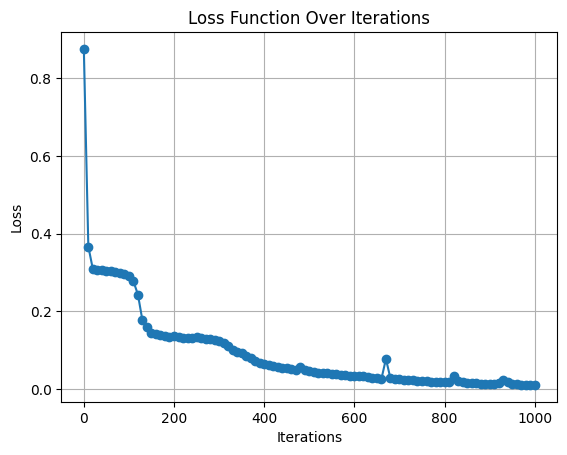

In [32]:
iterations = range(0, len(history) * 10, 10)  # Assuming losses are provided every 100 iterations

plt.plot(iterations, history, marker='o')
plt.title('Loss Function Over Iterations')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.grid()
plt.show()

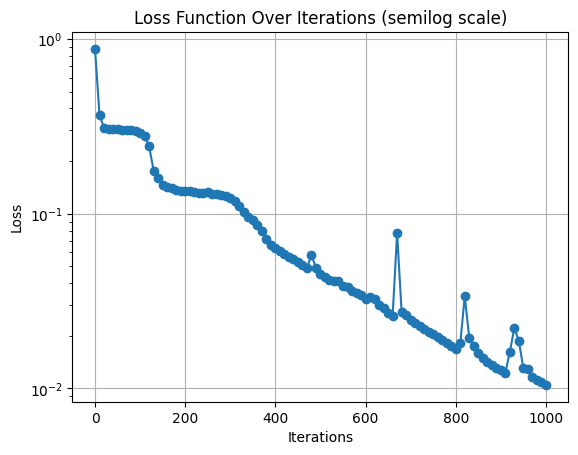

In [33]:
plt.semilogy(iterations, history, marker='o')
plt.title('Loss Function Over Iterations (semilog scale)')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.grid()
plt.show()

In [34]:
vp.u_NN(1.0,2.0)

-0.7189820346104658

In [35]:
x=np.linspace(0,1,100,dtype=np.float32)



def u_exact(x,y):

    return np.cos(2*np.pi*x)*np.sin(2*np.pi*y)


eval_exact=[u_exact(x[i],0.85) for i in range(len(x))]

eval_net=[vp.u_NN(x[i],0.85) for i in range(len(x))]

eval_exact=np.array(eval_exact)
eval_net=np.array(eval_net)

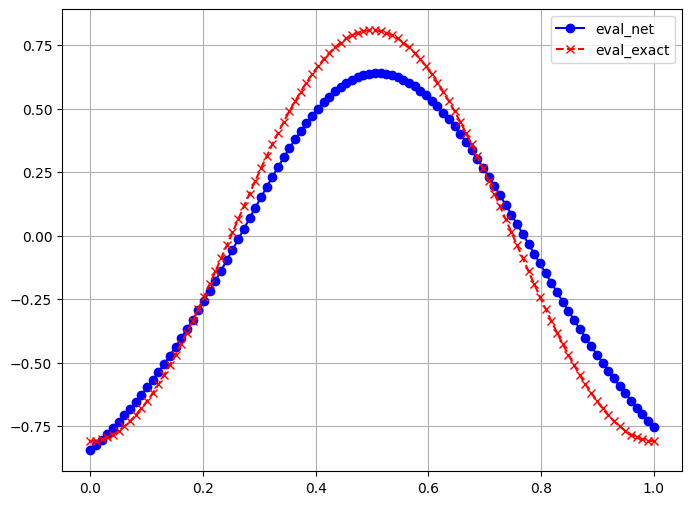

In [36]:
plt.figure(figsize=(8, 6))  # Set the figure size

# Plot the data
plt.plot(x, eval_net, label='eval_net', linestyle='-', marker='o', color='b')
plt.plot(x, eval_exact, label='eval_exact', linestyle='--', marker='x', color='r')
plt.grid()
plt.legend()

#if you want reproducibility put a seed


In [37]:
## Add surface plot
import numpy as np
x=np.linspace(0,1,50,dtype=np.float32)
XX,YY = np.meshgrid(x,x)
xx = XX.flatten()
yy = YY.flatten()

X = np.vstack((xx,yy)).transpose()
print(X)
Z = [vp.u_NN(x[0],x[1]) for x in X]

[[0.         0.        ]
 [0.02040816 0.        ]
 [0.04081633 0.        ]
 ...
 [0.9591837  1.        ]
 [0.97959185 1.        ]
 [1.         1.        ]]


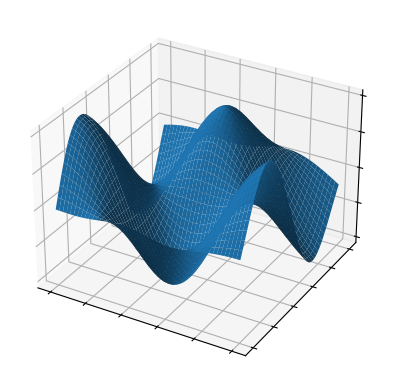

Text(0.5, 0.92, 'Original Code')

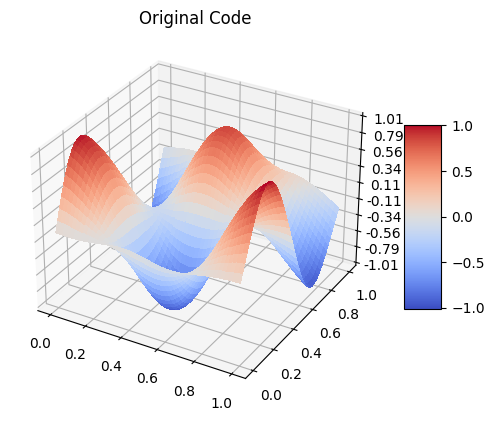

In [38]:
# Plot the surface
z = np.array(Z).flatten().reshape((50,50))
# z = np.reshape(z, (50,50))
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot_surface(XX, YY, z, vmin=z.min() * 2)

ax.set(xticklabels=[],
       yticklabels=[],
       zticklabels=[])

plt.show()

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
surf = ax.plot_surface(XX, YY, z, rstride=1, cstride=1, cmap=cm.coolwarm,
    linewidth=0, antialiased=False)
ax.set_zlim(-1.01, 1.01)

ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

fig.colorbar(surf, shrink=0.5, aspect=5)
plt.title('Original Code')

In [39]:
#integration
from scipy.integrate import dblquad
integral,error=dblquad(lambda x,y: (u_exact(x,y)-vp.u_NN(x,y))**2, 0.0, 1.0,0.0, 1.0)

L2_error=np.sqrt(integral)
print(L2_error,error)

KeyboardInterrupt: 

In [ ]:

indices = tf.constant([[[triangle[0],1]], [[triangle[1],1]], [[triangle[2],1]]])


In [ ]:
print(vp.NN.trainable_variables)

[<tf.Variable 'dense/kernel:0' shape=(2, 10) dtype=float64, numpy=
array([[-0.14358816,  0.08014836, -0.8226231 ,  0.26975844,  0.6215206 ,
        -0.05889021,  0.43069807, -0.68627619,  1.0563799 ,  0.10133199],
       [ 0.47411688, -0.466577  , -0.22848046, -1.50641732, -0.05275095,
        -0.54035119,  0.57330755, -0.00183728,  0.06921881,  0.58375504]])>, <tf.Variable 'dense/bias:0' shape=(10,) dtype=float64, numpy=
array([-0.22749617,  0.23805551, -0.07932891, -0.38456098, -0.11987032,
       -0.37202646, -0.83107563,  0.3535664 , -0.30545279, -0.56176156])>, <tf.Variable 'dense_1/kernel:0' shape=(10, 10) dtype=float64, numpy=
array([[ 0.01321466, -0.41052026, -0.38106843, -0.35394397,  0.47336837,
         0.65874134, -1.03150548,  0.37160507, -0.43493066, -0.78373229],
       [-0.41739959, -0.1141929 ,  0.4197078 , -0.23678659, -0.48991856,
        -0.43771563,  0.67448397, -0.14327611,  0.12729784,  0.01532789],
       [-0.62014645, -0.82697877, -0.38379193,  0.278703  ,  0.3

In [ ]:
tensor = tf.constant([[1, 1,1, 1]])    # tf.rank(tensor) == 2
indices = [[0,0]]           # num_updates == 2, index_depth == 2
updates = [5]                    # num_updates == 2
print(tf.tensor_scatter_nd_update(tensor, indices, updates))

print(vp.F_total_edges)


tf.Tensor([[5 1 1 1]], shape=(1, 4), dtype=int32)
tf.Tensor(
[[-8.49853253e-02]
 [ 2.45638679e-02]
 [-1.68949510e-01]
 [-8.21118934e-01]
 [-8.45565716e-01]
 [-6.43969170e-01]
 [-4.54544330e-02]
 [-1.67908161e-01]
 [ 6.23591995e-03]
 [ 1.76745557e-02]
 [-8.89708710e-03]
 [-4.44960499e-01]
 [-3.10504920e-01]
 [-2.04579699e-01]
 [-1.06275669e-08]
 [ 3.48984493e-01]
 [ 2.68031206e-01]
 [-3.34914037e-01]
 [-6.50862160e-01]
 [-3.97789761e-01]
 [-3.48984461e-01]
 [-7.40117076e-01]
 [ 0.00000000e+00]
 [-1.16068135e-01]
 [ 2.39095735e-04]
 [-2.91627024e-02]
 [ 2.62968430e-02]
 [ 1.86727228e-01]
 [ 0.00000000e+00]
 [ 6.18754360e-01]
 [ 0.00000000e+00]
 [ 3.29106301e-01]
 [ 7.41329805e-01]
 [ 4.58860494e-01]
 [ 5.31176375e-01]
 [-6.83607762e-02]
 [-1.34062375e-01]
 [-2.56624562e-01]
 [-1.68945088e-01]
 [ 1.82319621e-02]
 [-2.16833536e-02]
 [ 1.42809677e-01]
 [-9.45086710e-02]
 [ 6.84017639e-01]
 [ 6.31598549e-01]
 [ 5.14064661e-01]
 [-2.56508881e-01]
 [ 4.63266526e-01]
 [ 4.39327384e-01]
 [ 1.630

In [ ]:
vp.boundary_points

<tf.Tensor: shape=(320, 2), dtype=float64, numpy=
array([[0.    , 0.    ],
       [0.0125, 0.    ],
       [0.025 , 0.    ],
       [0.0375, 0.    ],
       [0.05  , 0.    ],
       [0.0625, 0.    ],
       [0.075 , 0.    ],
       [0.0875, 0.    ],
       [0.1   , 0.    ],
       [0.1125, 0.    ],
       [0.125 , 0.    ],
       [0.1375, 0.    ],
       [0.15  , 0.    ],
       [0.1625, 0.    ],
       [0.175 , 0.    ],
       [0.1875, 0.    ],
       [0.2   , 0.    ],
       [0.2125, 0.    ],
       [0.225 , 0.    ],
       [0.2375, 0.    ],
       [0.25  , 0.    ],
       [0.2625, 0.    ],
       [0.275 , 0.    ],
       [0.2875, 0.    ],
       [0.3   , 0.    ],
       [0.3125, 0.    ],
       [0.325 , 0.    ],
       [0.3375, 0.    ],
       [0.35  , 0.    ],
       [0.3625, 0.    ],
       [0.375 , 0.    ],
       [0.3875, 0.    ],
       [0.4   , 0.    ],
       [0.4125, 0.    ],
       [0.425 , 0.    ],
       [0.4375, 0.    ],
       [0.45  , 0.    ],
       [0.4625, 0.    ],


In [ ]:
a=tf.constant([1.0 ,2.0])


print(a)



tf.Tensor([1. 2.], shape=(2,), dtype=float32)


In [ ]:
b=tf.Variable([1.0 ,2.0])

print(b)

b[0].assign(6.0)

print(b)


<tf.Variable 'Variable:0' shape=(2,) dtype=float32, numpy=array([1., 2.], dtype=float32)>
<tf.Variable 'Variable:0' shape=(2,) dtype=float32, numpy=array([6., 2.], dtype=float32)>


In [ ]:
x=tf.constant(6.0)

def f(x):
    return x*x


with tf.GradientTape() as tape:
    tape.watch(x)
    res=f(x)
grad=tape.gradient(res,x)


print(res,grad,12)


tf.Tensor(36.0, shape=(), dtype=float32) tf.Tensor(12.0, shape=(), dtype=float32) 12


In [ ]:
x=tf.Variable(3.0)
y=tf.Variable(1.0)

def f(x):
    return np.sin(x)



with tf.GradientTape(persistent=True) as tape:
    #y.assign_add(x)
    z=x+y
    res=f(z)        #(x+y)^2
    temp=np.array(res)

grad=tape.gradient(res,x)  
#grad_=tape.gradient(temp,x)


print(res,grad)
print(grad_)

AttributeError: 'numpy.float32' object has no attribute '_id'

In [ ]:
x=.constant(3.0)
def f(x):
    return x*x



with tf.GradientTape() as tape:
    #y.assign_add(x)
    tape.watch(x)
    res=f(x)


grad=tape.gradient(res,x)   


print(res,grad)

ValueError: Passed in object 3.0 of type 'ndarray', not tf.Tensor or tf.Variable or ExtensionType.

In [ ]:
x=tf.constant((1,2))

print(x)

x[0]=1

tf.Tensor([1 2], shape=(2,), dtype=int32)


TypeError: 'tensorflow.python.framework.ops.EagerTensor' object does not support item assignment

In [ ]:
import tensorflow as tf

# Define the shape of the row vector
vector_length = 10

# Specify the indices where you want to place non-zero values
non_zero_indices = tf.constant([[2], [5], [8]], dtype=tf.int32)

# Specify the values to be placed at the specified indices
non_zero_values = tf.constant([[1.0], [2.0], [3.0]], dtype=tf.float32)

# Create the row vector with zeros and the specified values
row_vector = tf.scatter_nd(non_zero_indices, non_zero_values, shape=(vector_length,1))

# Print the result
print(row_vector.numpy())


print(row_vector[1][0])




[[0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [2.]
 [0.]
 [0.]
 [3.]
 [0.]]
tf.Tensor(0.0, shape=(), dtype=float32)


In [ ]:
x=tf.Variable(tf.zeros((1,2),dtype=tf.float64))
print(x)

<tf.Variable 'Variable:0' shape=(1, 2) dtype=float64, numpy=array([[0., 0.]])>
